In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# --- Configuration ---
DATA_FILE_PATH = "data/time_series_forecasting_data.csv" # !!! REPLACE WITH YOUR FILE PATH !!!
TARGET_VARIABLE = 'svr1'  # Column to predict (e.g., latency)
DATETIME_COLUMN = 'datetime'

# Features to use (excluding target and datetime after it's set as index)
POTENTIAL_FEATURES = ['Bitrate', 'Retransmissions', 'send_data', 'bitrate_lag1']

In [5]:
# --- 1. Load Data ---
print(f"Loading data from {DATA_FILE_PATH}...")
try:
    df = pd.read_csv(DATA_FILE_PATH)
except FileNotFoundError:
    print(f"ERROR: File not found at {DATA_FILE_PATH}. Please check the path.")
    exit()
except Exception as e:
    print(f"Error loading CSV: {e}")
    exit()

print("Data loaded successfully. Shape:", df.shape)
print("First 5 rows:\n", df.head())
print("\nData types:\n", df.dtypes)

Loading data from data/time_series_forecasting_data.csv...
Data loaded successfully. Shape: (443, 6)
First 5 rows:
                     datetime        svr1   Bitrate  Retransmissions  \
0  2022-07-04 05:00:00+10:00  164.761605  9.587114          19212.0   
1  2022-07-04 06:00:00+10:00  137.114572  9.674189          60355.0   
2  2022-07-04 07:00:00+10:00  119.750291  9.124099          54765.0   
3  2022-07-04 08:00:00+10:00  172.741844  8.571186          57025.0   
4  2022-07-04 09:00:00+10:00  243.929796  8.165318          59450.0   

    send_data  bitrate_lag1  
0   53.821966           NaN  
1  172.982437      9.587114  
2  105.946353      9.674189  
3  127.174063      9.124099  
4  128.502862      8.571186  

Data types:
 datetime            object
svr1               float64
Bitrate            float64
Retransmissions    float64
send_data          float64
bitrate_lag1       float64
dtype: object


In [6]:
# --- 2. Preprocessing and Feature Engineering ---
# Convert datetime column
if DATETIME_COLUMN not in df.columns:
    print(f"ERROR: Datetime column '{DATETIME_COLUMN}' not found in the CSV.")
    exit()
try:
    df[DATETIME_COLUMN] = pd.to_datetime(df[DATETIME_COLUMN])
except Exception as e:
    print(f"Error converting '{DATETIME_COLUMN}' to datetime: {e}. Check its format.")
    exit()

# Set datetime as index
df = df.set_index(DATETIME_COLUMN)
df = df.sort_index()  # Ensure chronological order

# Handle missing values (example: forward fill, then backward fill)
initial_missing = df.isnull().sum().sum()
if initial_missing > 0:
    print(f"Found {initial_missing} missing values. Applying ffill and bfill.")
    df = df.ffill().bfill()
    if df.isnull().sum().sum() > 0:  # If still missing, fill with median or 0
        print("Still missing values after ffill/bfill. Filling with 0.")
        df = df.fillna(0)  # Or use df.fillna(df.median()) if more appropriate

# Ensure target variable exists
if TARGET_VARIABLE not in df.columns:
    print(f"ERROR: Target variable '{TARGET_VARIABLE}' not found in the CSV columns.")
    print(f"Available columns: {df.columns.tolist()}")
    exit()

# Ensure potential features are numeric and exist
selected_features = []
for feature in POTENTIAL_FEATURES:
    if feature in df.columns:
        if pd.api.types.is_numeric_dtype(df[feature]):
            selected_features.append(feature)
        else:
            print(f"Warning: Feature '{feature}' is not numeric and will be skipped. Dtype: {df[feature].dtype}")
    else:
        print(f"Warning: Feature '{feature}' not found in columns and will be skipped.")

if not selected_features:
    print("ERROR: No valid numeric features selected or found. Cannot proceed with model training.")
    exit()

print(f"Selected features for model: {selected_features}")

# Create time-based features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek  # Monday=0, Sunday=6
df['dayofyear'] = df.index.dayofyear
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['weekofyear'] = df.index.isocalendar().week.astype(int)

time_features = ['hour', 'dayofweek', 'dayofyear', 'month', 'quarter', 'weekofyear']
all_features = selected_features + time_features

# Define X (features) and y (target)
X = df[all_features]
y = df[TARGET_VARIABLE]

print("Preprocessing and feature engineering complete.")
print("Shape of X (features):", X.shape)
print("Shape of y (target):", y.shape)
print("Features used:\n", X.head())

Found 1 missing values. Applying ffill and bfill.
Selected features for model: ['Bitrate', 'Retransmissions', 'send_data', 'bitrate_lag1']
Preprocessing and feature engineering complete.
Shape of X (features): (443, 10)
Shape of y (target): (443,)
Features used:
                             Bitrate  Retransmissions   send_data  \
datetime                                                           
2022-07-04 05:00:00+10:00  9.587114          19212.0   53.821966   
2022-07-04 06:00:00+10:00  9.674189          60355.0  172.982437   
2022-07-04 07:00:00+10:00  9.124099          54765.0  105.946353   
2022-07-04 08:00:00+10:00  8.571186          57025.0  127.174063   
2022-07-04 09:00:00+10:00  8.165318          59450.0  128.502862   

                           bitrate_lag1  hour  dayofweek  dayofyear  month  \
datetime                                                                     
2022-07-04 05:00:00+10:00      9.587114     5          0        185      7   
2022-07-04 06:00:00+10:00

In [7]:
# --- 3. Data Splitting (Time-Series Aware) ---
test_size_percentage = 0.2  # Use last 20% of data for testing
split_index = int(len(df) * (1 - test_size_percentage))

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"\nSplitting data: Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Splitting data: Train set size: 354, Test set size: 89


In [8]:
# --- 4. Model Training ---
# Using RandomForestRegressor 
print("\nTraining RandomForestRegressor model...")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=10)

# Handle any remaining NaNs in X_train that might have been introduced by feature processing (though unlikely with current steps)
X_train = X_train.fillna(0)  # Or a more sophisticated imputation
y_train = y_train.fillna(0)
model.fit(X_train, y_train)
print("Model training complete.")


Training RandomForestRegressor model...
Model training complete.


In [9]:
# --- 5. Make Predictions ---
print("\nMaking predictions on the test set...")
X_test = X_test.fillna(0)  # Ensure test set has same imputation as train
y_pred = model.predict(X_test)


Making predictions on the test set...


In [10]:
# --- 6. Evaluate the Model ---
print("\nEvaluating model performance...")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"  Mean Absolute Error (MAE): {mae:.4f}")

# To interpret MAE, consider the mean of the target variable in the test set
print(f"  Mean of target variable in test set ({TARGET_VARIABLE}): {y_test.mean():.4f}")


Evaluating model performance...
  Root Mean Squared Error (RMSE): 74.1409
  Mean Absolute Error (MAE): 49.1266
  Mean of target variable in test set (svr1): 137.6224


In [11]:
# --- 7. Feature Importance (for tree-based models) ---
if hasattr(model, 'feature_importances_'):
    print("\nFeature Importances:")
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print(importances)


Feature Importances:
Bitrate            0.352218
dayofyear          0.327053
Retransmissions    0.193858
bitrate_lag1       0.053072
hour               0.031773
send_data          0.027476
weekofyear         0.009939
dayofweek          0.004610
month              0.000000
quarter            0.000000
dtype: float64


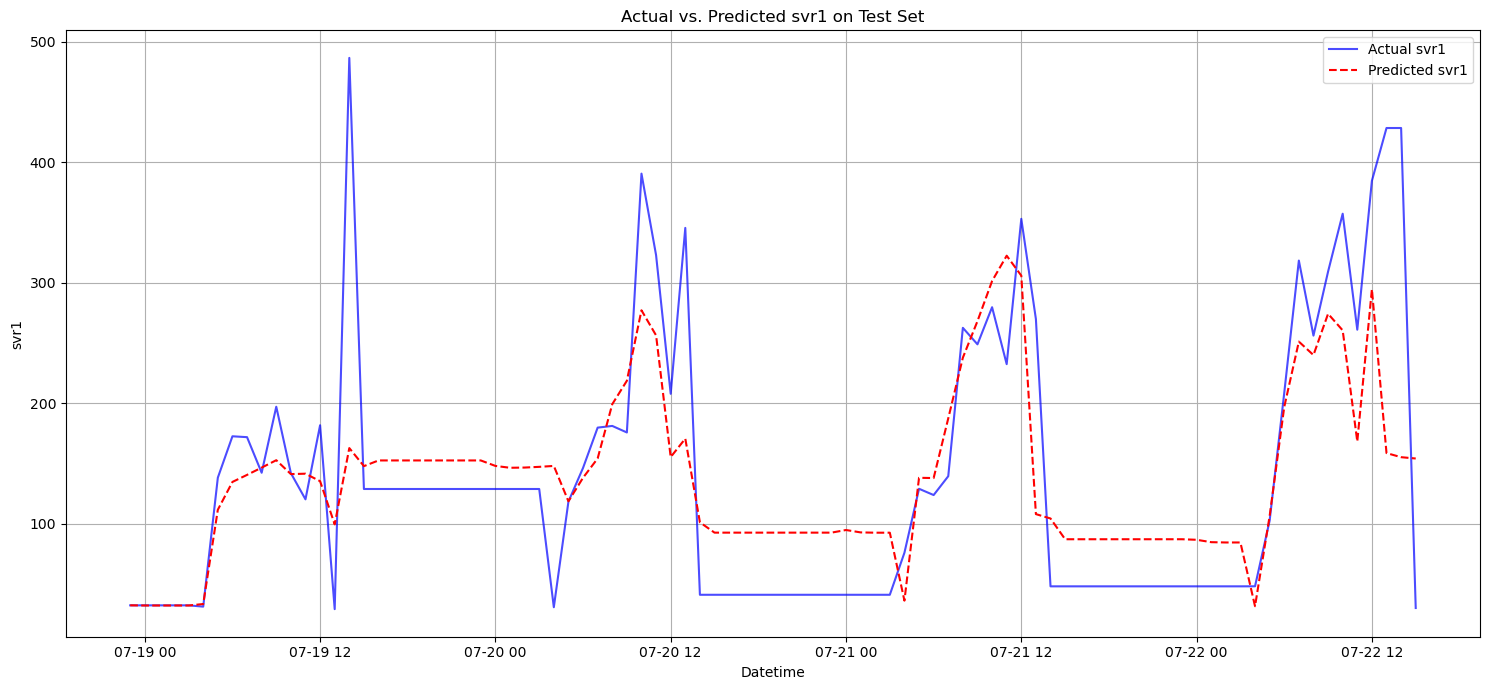

In [12]:
# --- 8. Plotting Predictions vs Actuals (for a visual check) ---
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual ' + TARGET_VARIABLE, color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted ' + TARGET_VARIABLE, color='red', linestyle='--')
plt.title(f'Actual vs. Predicted {TARGET_VARIABLE} on Test Set')
plt.xlabel('Datetime')
plt.ylabel(TARGET_VARIABLE)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()